**PLAYING WITH THE TENSORFLOW API**

***

***

# Packages

In [1]:
# Essential libraries.
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import tensorflow as tf
import pandas as pd
import dataframe_image as dfi

# Modules.
import tensorflow.keras.layers as tfl
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from sklearn.metrics import classification_report

# Disable GPU.
# os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

# Information.
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.9.1
Num GPUs Available:  1


2022-10-17 12:41:20.333378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 12:41:20.340026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 12:41:20.340174: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
np.random.seed(42)
tf.random.set_seed(42)

***

***

# Dataset

## Split into training and validation sets

When training and evaluating deep learning models in Keras, generating a dataset from image files stored on disk is simple and fast. Call `image_data_set_from_directory()` to read from the directory and create both training and validation datasets. 

If you're specifying a validation split, you'll also need to specify the subset for each portion. Just set the training set to `subset='training'` and the validation set to `subset='validation'`.

You'll also set your seeds to match each other, so your training and validation sets don't overlap.

Then calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images from the subdirectories class_a and class_b, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b).

In [3]:
# Samples info.
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
path_dir = 'Sentinel2GlobalLULC/Sentinel2LULC_JPEG/' # /home/sfandres/Downloads/Sentinel-dataset/'    

# Dataset info.
split_train_val = 0.3    # 0.1
shuffle = True

# Train set.
train_dataset = image_dataset_from_directory(path_dir,
                                             label_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             shuffle=shuffle,
                                             seed=42,
                                             validation_split=split_train_val,
                                             subset='training')

# Validation set.
validation_dataset = image_dataset_from_directory(path_dir,
                                                  label_mode='categorical',
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  shuffle=shuffle,
                                                  seed=42,
                                                  validation_split=split_train_val,
                                                  subset='validation')

Found 194877 files belonging to 29 classes.
Using 136414 files for training.


2022-10-17 12:41:28.172977: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-17 12:41:28.174263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 12:41:28.174415: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 12:41:28.174517: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Found 194877 files belonging to 29 classes.
Using 58463 files for validation.


As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.

In [4]:
# Test set.
ratio_val_test = 3    # 18
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // ratio_val_test)
validation_dataset = validation_dataset.skip(val_batches // ratio_val_test)

validation_dataset, test_dataset = test_dataset, validation_dataset

# # Show stats.
# print('Training batches: %d' % tf.data.experimental.cardinality(train_dataset))
# print('Training samples: ' + str(len(train_dataset) * BATCH_SIZE))

# print('\nValidation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
# print('Validation samples: ' + str(len(validation_dataset) * BATCH_SIZE))

# print('\nTest batches: %d' % tf.data.experimental.cardinality(test_dataset))
# print('Test samples: ' + str(len(test_dataset) * BATCH_SIZE))

# print('\nTotal approx.: ' + str((len(train_dataset) + len(validation_dataset) + len(test_dataset)) * BATCH_SIZE))

## Some stats

In [5]:
# Dealing with the different classes.
class_names = train_dataset.class_names
n_classes = len(class_names)

# Show more stats.
print('Classes: ', class_names)
print('Number of classes: ', n_classes)

Classes:  ['01_BarrenLands___jpeg', '02_MossAndLichen_jpeg', '03_Grasslands____jpeg', '04_ShrublandOpen_jpeg', '05_SrublandClose_jpeg', '06_ForestsOpDeBr_jpeg', '07_ForestsClDeBr_jpeg', '08_ForestsDeDeBr_jpeg', '09_ForestsOpDeNe_jpeg', '10_ForestsClDeNe_jpeg', '11_ForestsDeDeNe_jpeg', '12_ForestsOpEvBr_jpeg', '13_ForestsClEvBr_jpeg', '14_ForestsDeEvBr_jpeg', '15_ForestsOpEvNe_jpeg', '16_ForestsClEvNe_jpeg', '17_ForestsDeEvNe_jpeg', '18_WetlandMangro_jpeg', '19_WetlandSwamps_jpeg', '20_WetlandMarshl_jpeg', '21_WaterBodyMari_jpeg', '22_WaterBodyCont_jpeg', '23_PermanentSnow_jpeg', '24_CropSeasWater_jpeg', '25_CropCereaIrri_jpeg', '26_CropCereaRain_jpeg', '27_CropBroadIrri_jpeg', '28_CropBroadRain_jpeg', '29_UrbanBlUpArea_jpeg']
Number of classes:  29


## Show some examples from the training set

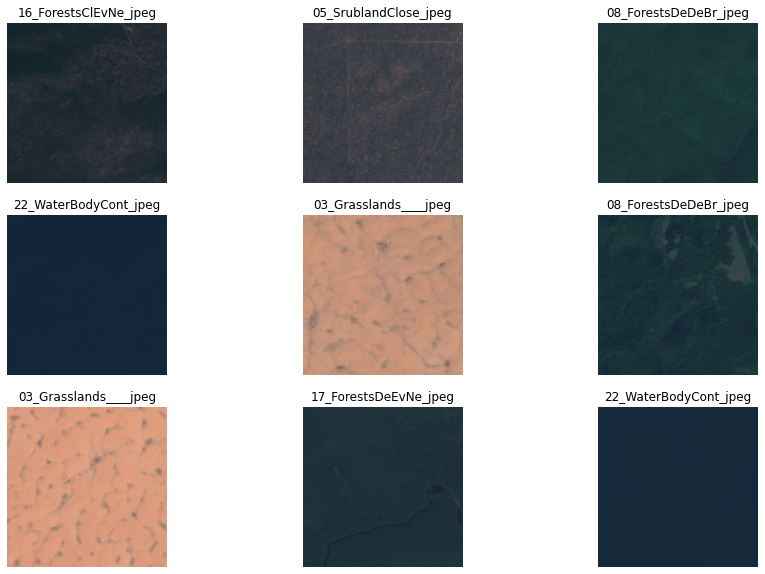

In [6]:
# Example.
plt.figure(figsize=(15, 10))
for images, labels in train_dataset.take(1):    # Take a batch.
    for i in range(9):                          # Take nine images.
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # plt.title(class_names[labels[i]])                # No one-hot.
        plt.title(class_names[np.argmax(labels[i])])       # One-hot.
        plt.axis("off")

***

***

# Preprocesses

## Configure the dataset for performance

Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from your input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

You can set the number of elements to prefetch manually, or you can use `tf.data.experimental.AUTOTUNE` to choose the parameters automatically. Autotune prompts `tf.data` to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those times into an optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations.

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the data performance guide.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Check if dataset is balanced (three datasets)

In [9]:
target_dataset = [train_dataset,
                  validation_dataset,
                  test_dataset]

ds_labels = {}
ds_samples = {}

for ds, i in zip(target_dataset, range(len(target_dataset))):
    labels = []
    for x, y in ds:
        # If one hot encoded, then apply argmax.
        labels.append(np.argmax(y, axis=-1))

        # Not one hot encoded.
        # labels.append(y.numpy())

    # Concatenate asuming dataset was batched.
    labels = np.concatenate(labels, axis=0)

    # Count unique labels.
    ds_labels[i], ds_samples[i] = np.unique(labels, return_counts=True)

Training batches: 4263
Training samples: 136416 (70.0%)

Validation batches: 609
Validation samples: 19488 (10.0%)

Test batches: 1218
Test samples: 38976 (20.0%)

Total approx.: 194880


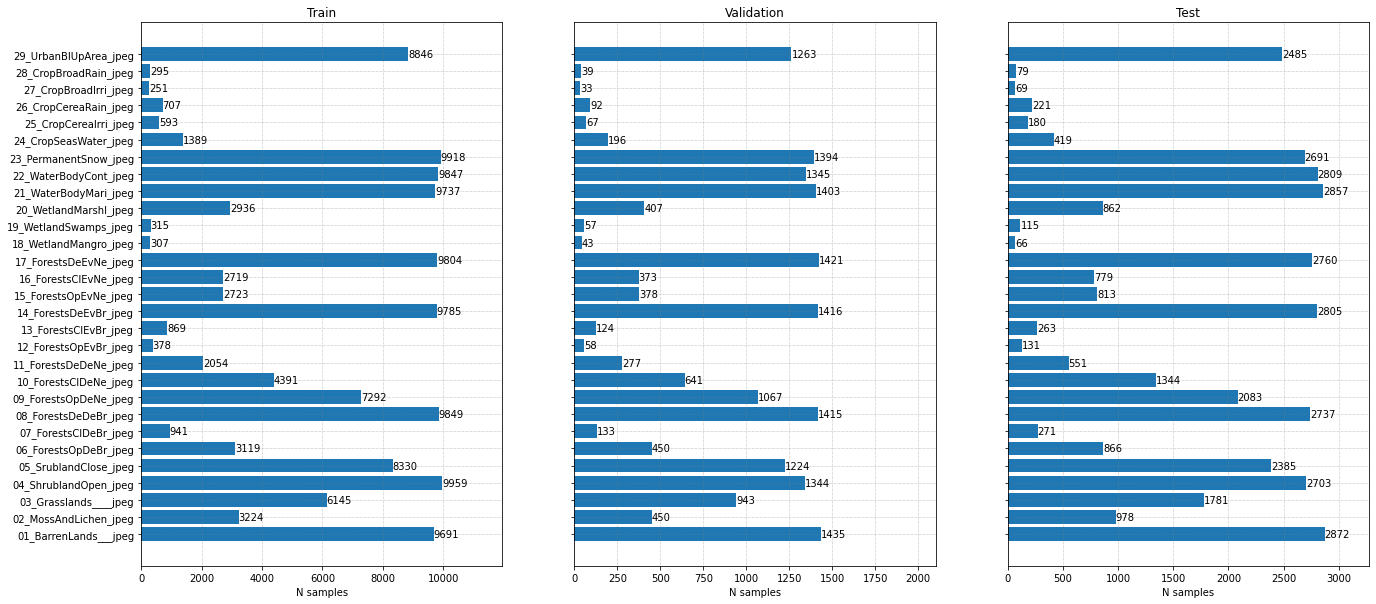

In [16]:
# Set up subplot.
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row')

# Set width and height.
fig.set_figwidth(22)
fig.set_figheight(10)

dataset_labels = ['Train',
                  'Validation',
                  'Test']

for i in range(len(target_dataset)):
    bars = ax[i].barh(class_names, ds_samples[i])    # class_names
    ax[i].bar_label(bars)
    ax[i].set_title(dataset_labels[i])
    ax[i].set_xlim(0, max(ds_samples[i]) + 2000/(1+i*2))

# Hide x labels and tick labels for top plots
# and y ticks for right plots.
for axs in ax.flat:
    axs.label_outer()
    axs.set(xlabel='N samples')
    axs.grid(color='gray', linestyle=':', linewidth=.5)
    # axs.legend(loc='best')

# Show stats.
training_samples = len(train_dataset) * BATCH_SIZE
validation_samples = len(validation_dataset) * BATCH_SIZE
test_samples = len(test_dataset) * BATCH_SIZE
total_samples = training_samples + validation_samples + test_samples
print('Training batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Training samples: ' + str(training_samples) + ' (' + str(100*training_samples/total_samples) + '%)')

print('\nValidation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Validation samples: ' + str(validation_samples) + ' (' + str(100*validation_samples/total_samples) + '%)')

print('\nTest batches: %d' % tf.data.experimental.cardinality(test_dataset))
print('Test samples: ' + str(test_samples) + ' (' + str(100*test_samples/total_samples) + '%)')

print('\nTotal approx.: ' + str(total_samples))

## Use data augmentation

To increase diversity in the training set and help your model learn the data better, it's standard practice to augment the images by transforming them, i.e., randomly flipping and rotating them. Keras' Sequential API offers a straightforward method for these kinds of data augmentations, with built-in, customizable preprocessing layers. These layers are saved with the rest of your model and can be re-used later.  Ahh, so convenient! 

As always, you're invited to read the official docs, which you can find for data augmentation [here](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [11]:
# This does not improve the results but I think it
# is due to the nature of the dataset samples.
data_augmentation = tf.keras.Sequential([
    tfl.RandomFlip("horizontal_and_vertical", seed=42),
    tfl.RandomRotation(0.2, seed=42),
    tfl.RandomZoom(0.1, seed=42),
])

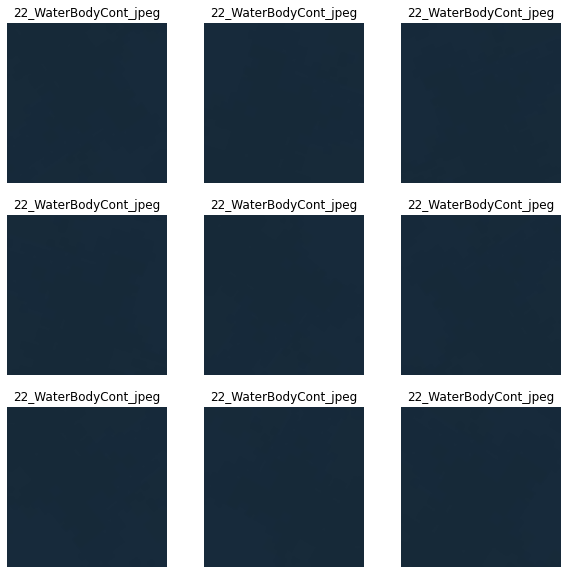

In [12]:
for image, label in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image, first_label = image[0], label[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.title(class_names[np.argmax(first_label)])
        plt.axis('off')

***

***

# Create the base model from the pre-trained CNNs

In [13]:
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input, decode_predictions

In [14]:
data_aug = False
model_name = 'ResNet50'

## Model definition

In [15]:
def get_model(data_aug=False):

    # Create the base model from the pre-trained model ResNet50
    input_shape = IMG_SIZE + (3,)

    # Loading the pre-trained model without the top layers.
    base_model = ResNet50(include_top=False,
                          weights='imagenet',
                          input_shape=input_shape)

    # Freeze the base model.
    base_model.trainable = False

    # Create the input layer.
    inputs = tf.keras.Input(shape=input_shape)

    # Apply data augmentation to the inputs.
    if data_aug:
        inputs = data_augmentation(inputs, training=True)

    # Data preprocessing using the same weights the model was trained on.
    x = preprocess_input(inputs)

    # Set training to False to avoid keeping track of statistics in the batch norm layer.
    x = base_model(x, training=False)

    # Add the new Binary classification layers.
    # Use global avg pooling to summarize the info in each channel.
    x = tfl.GlobalAveragePooling2D()(x)

    # Include dropout to avoid overfitting.
    x = tfl.Dropout(0.2)(x)

    # Output layer.
    x = tfl.Flatten()(x)
    outputs = tfl.Dense(n_classes, activation='softmax')(x)

    # Create model.
    model = tf.keras.Model(inputs, outputs, name=model_name)

    return model

## Callbacks

In [16]:
# Custom callback: New print during fit.
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print(" - val/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

cb_val_train_ratio = PrintValTrainRatioCallback()

# TensorBoard logs callback.
def get_run_logdir(root_logdir):
    import time
    run_id = time.strftime('run-%Y_%m_%d-%H_%M_%S')
    run_id = run_id + '-' + (model_name) + '-Data_aug_' + str(data_aug)
    return os.path.join(root_logdir, run_id)

root_logdir = os.path.join(os.curdir, 'my_logs')
run_logdir = get_run_logdir(root_logdir) # e.g., './my_logs/run_2019_06_07-15_15_22'

cb_tensorboard = tf.keras.callbacks.TensorBoard(run_logdir)

# Checkpoint callback: epoch in the file name.
checkpoint_path =  model_name + '-epoch-{epoch:02d}-loss-{loss:.3f}-val_loss-{val_loss:.3f}-val_acc-{val_categorical_accuracy:.3f}.h5'
checkpoint_filepath = os.path.join(run_logdir, checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch')

## Training

In [17]:
import tensorflow_addons as tfa

In [18]:
# Create a new model instance.
model = get_model(data_aug)

# Compile.
base_learning_rate = 0.001    # 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(),
                       tfa.metrics.F1Score(num_classes=n_classes, average='macro')])    # bigger penalisation when your model does not perform well with the minority classes.

# Summary.
model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0  

In [19]:
# Train the model with the new callback.
initial_epochs = 25
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[cb_val_train_ratio,
                               cb_tensorboard,
                               cp_callback])

Epoch 1/10


2022-09-28 10:06:27.376500: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


   3/4263 [..............................] - ETA: 4:17 - loss: 3.8854 - categorical_accuracy: 0.0104 - f1_score: 0.0086          

2022-09-28 10:06:29.158963: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4263/4263 [==============================] - ETA: 0s - loss: 0.3018 - categorical_accuracy: 0.8984 - f1_score: 0.8083 - val/train: 0.65

Epoch 1: val_loss improved from inf to 0.19627, saving model to ./my_logs/run-2022_09_28-10_06_23-ResNet50-Data_aug_False/ResNet50-epoch-01-loss-0.302-val_loss-0.196-val_acc-0.929.h5
4263/4263 [==============================] - 299s 69ms/step - loss: 0.3018 - categorical_accuracy: 0.8984 - f1_score: 0.8083 - val_loss: 0.1963 - val_categorical_accuracy: 0.9289 - val_f1_score: 0.8685
Epoch 2/10
4263/4263 [==============================] - ETA: 0s - loss: 0.2032 - categorical_accuracy: 0.9258 - f1_score: 0.8739 - val/train: 0.88

Epoch 2: val_loss improved from 0.19627 to 0.17903, saving model to ./my_logs/run-2022_09_28-10_06_23-ResNet50-Data_aug_False/ResNet50-epoch-02-loss-0.203-val_loss-0.179-val_acc-0.934.h5
4263/4263 [==============================] - 295s 69ms/step - loss: 0.2032 - categorical_accuracy: 0.9258 - f1_score: 0.8739 - val_loss: 0.1790

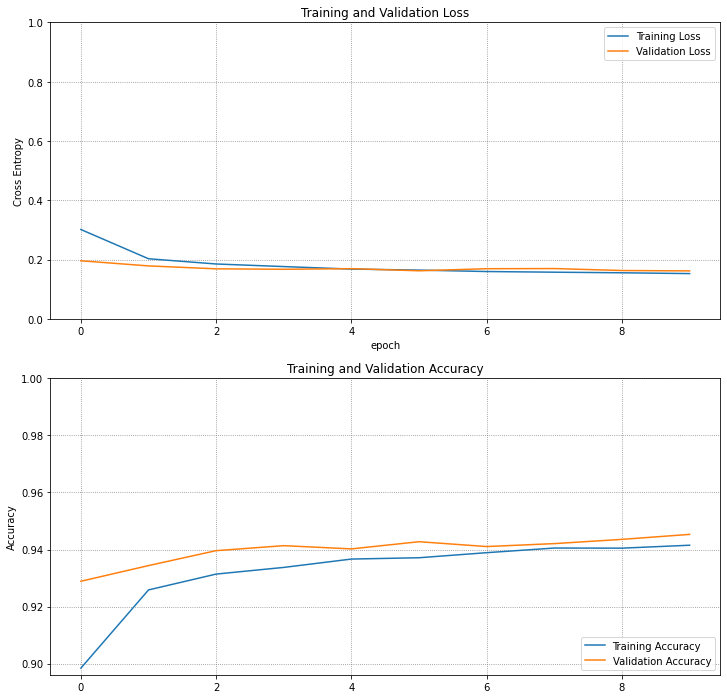

In [20]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid(color='gray', linestyle=':', linewidth=.8)

plt.subplot(2, 1, 2)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.grid(color='gray', linestyle=':', linewidth=.8)

plt.show()

***

***

# Fine-tuning

## Un-freeze the top layers of the model

In [21]:
# Un-freeze the base_model.
base_model = model.layers[3]     # model.get_layer('resnet50')
base_model.trainable = True

# Let's take a look to see how many layers are in the base model.
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards.
fine_tune_at = 100

# Freeze all the layers before the 'fine_tune_at' layer.
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Summary again.
model.summary()

Number of layers in the base model:  175
Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout

## Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [22]:
# New compilation with lower lr.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate / 10),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(),
                       tfa.metrics.F1Score(num_classes=n_classes, average='macro')])

## Continue training the model

In [23]:
fine_tune_epochs = 75
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[cb_val_train_ratio,
                                    cb_tensorboard,
                                    cp_callback])

Epoch 10/20
4263/4263 [==============================] - ETA: 0s - loss: 0.1879 - categorical_accuracy: 0.9286 - f1_score: 0.8737 - val/train: 0.72

Epoch 10: val_loss improved from 0.16219 to 0.13555, saving model to ./my_logs/run-2022_09_28-10_06_23-ResNet50-Data_aug_False/ResNet50-epoch-10-loss-0.188-val_loss-0.136-val_acc-0.950.h5
4263/4263 [==============================] - 443s 103ms/step - loss: 0.1879 - categorical_accuracy: 0.9286 - f1_score: 0.8737 - val_loss: 0.1355 - val_categorical_accuracy: 0.9501 - val_f1_score: 0.9184
Epoch 11/20
4263/4263 [==============================] - ETA: 0s - loss: 0.1272 - categorical_accuracy: 0.9511 - f1_score: 0.9232 - val/train: 0.84

Epoch 11: val_loss improved from 0.13555 to 0.10640, saving model to ./my_logs/run-2022_09_28-10_06_23-ResNet50-Data_aug_False/ResNet50-epoch-11-loss-0.127-val_loss-0.106-val_acc-0.960.h5
4263/4263 [==============================] - 437s 103ms/step - loss: 0.1272 - categorical_accuracy: 0.9511 - f1_score: 0.92

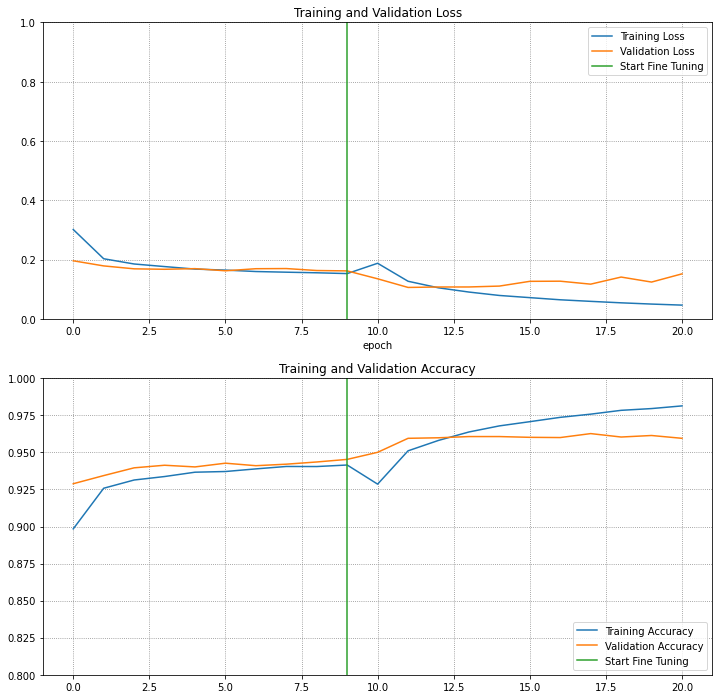

In [24]:
acc += history_fine.history['categorical_accuracy']
val_acc += history_fine.history['val_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

fig = plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid(color='gray', linestyle=':', linewidth=.8)

plt.subplot(2, 1, 2)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(color='gray', linestyle=':', linewidth=.8)

plt.show()

In [25]:
filename = 'loss_accuracy_train_val.png'
fig.savefig(os.path.join(run_logdir, filename),
            bbox_inches='tight')

***

***

# Tensorboard

In [26]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

***

***

# Saving and loading

## When only the weights had been saved

In [27]:
# Manually save only weights.
# model.save_weights("weights.h5")

# Load only weights.
# reconstructed_model = get_model()
# reconstructed_model.load_weights("weights.h5")
# reconstructed_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
#                             loss=tf.keras.losses.CategoricalCrossentropy(),
#                             metrics=[tf.keras.metrics.CategoricalAccuracy()])

## When the whole model had been sabed

Keras also supports saving a single HDF5 file containing the model's architecture, weights values, and compile() information. It is a light-weight alternative to SavedModel.

If saving only weights I get an error related to saving trainable and non-trainable weights all together.

In [28]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
# model.save("my_model")

# It can be used to reconstruct the model identically.
# new_model = tf.keras.models.load_model("my_model")

In [29]:
# Review the resulting checkpoints (whole model with .h5) and choose the latest one.
files_in_logdir = os.listdir(run_logdir)
models = [file for file in files_in_logdir if file.endswith(".h5")]
latest_model_name = sorted(models, reverse=True)[0]
model_path = os.path.join(run_logdir, latest_model_name)
print(model_path)

# Load again the model.
reconstructed_model = tf.keras.models.load_model(model_path)

# Reconstructed model summary.
reconstructed_model.summary()

./my_logs/run-2022_09_28-10_06_23-ResNet50-Data_aug_False/ResNet50-epoch-11-loss-0.127-val_loss-0.106-val_acc-0.960.h5
Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
     

***

***

# Evaluation

In [30]:
target_dataset = test_dataset

## Accuracy

In [31]:
# Check if necessary.
# loss, accuracy = reconstructed_model.evaluate(target_dataset)
# print('Reconstructed model\n'
#       + '- Loss on test: ' + str(round(loss, 6))
#       + '\n- Acc on test: ' + str(round(accuracy, 6)))

In [32]:
# Check if necessary.
loss, accuracy, f1 = model.evaluate(target_dataset)
print('Current model\n'
      + '- Loss on test: ' + str(round(loss, 6))
      + '\n- Acc on test: ' + str(round(accuracy, 6))
      + '\n- F1 on test: ' + str(round(f1, 6)))

1218/1218 [==============================] - 77s 61ms/step - loss: 0.1662 - categorical_accuracy: 0.9583 - f1_score: 0.9340
Current model
- Loss on test: 0.166245
- Acc on test: 0.958281
- F1 on test: 0.93401


## Confusion matrix

In [33]:
y_pred = []    # Store predicted labels.
y_true = []    # Store true labels.

# Iterate over the dataset.
for image_batch, label_batch in target_dataset:    # Use dataset.unbatch() with repeat.
    
    # Append true labels.
    y_true.append(label_batch)
    
    # Compute predictions.
    preds = model.predict(image_batch, verbose=0)
    
    # Append predicted labels.
    y_pred.append(np.argmax(preds, axis=-1))

# Convert the true and predicted labels into tensors.
correct_labels = tf.concat([item for item in y_true], axis=0)
predicted_labels = tf.concat([item for item in y_pred], axis=0)

# Convert from one-hot.
correct_labels = tf.argmax(correct_labels, axis=1)

# Compute confusion matrix and decode labels.
cm = tf.math.confusion_matrix(correct_labels, predicted_labels)
labels = [class_names[i] for i in range(n_classes)]

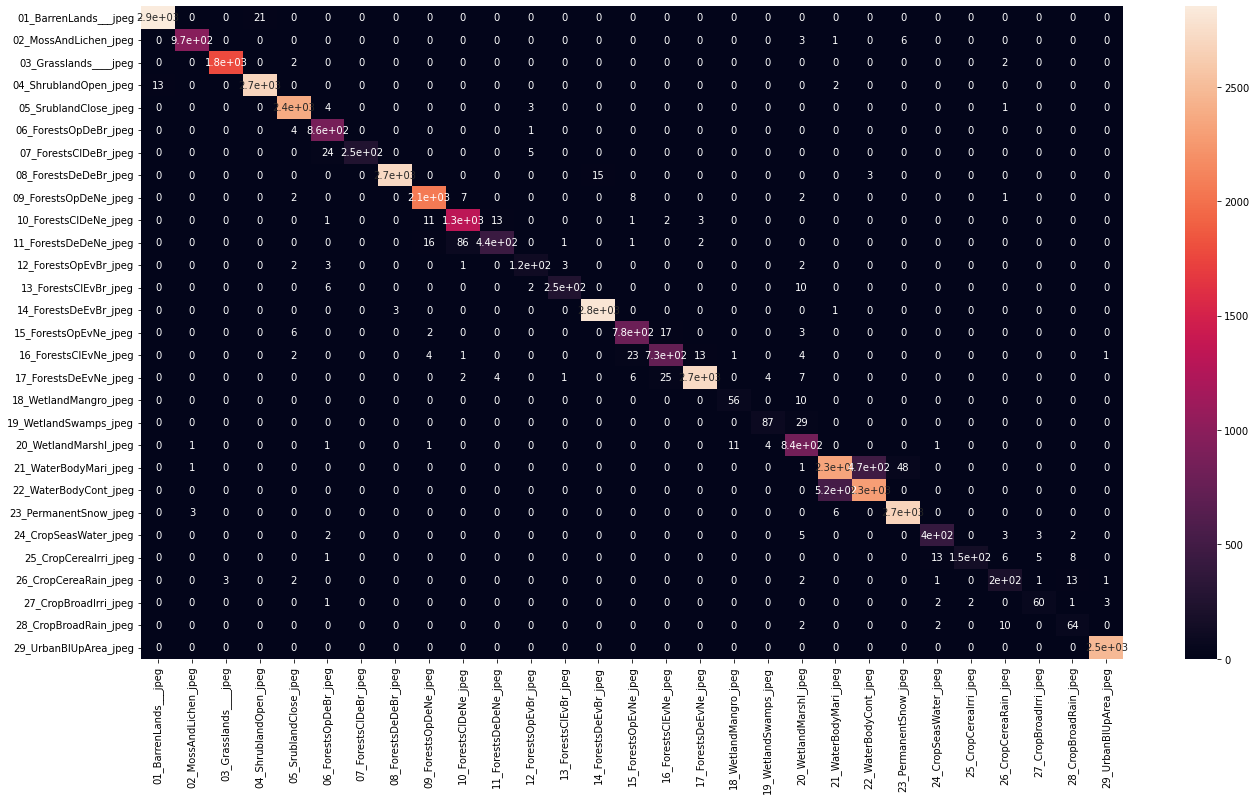

In [34]:
fig = plt.figure(figsize = (22, 12))
sns_plot = sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels)
plt.show()

In [35]:
fig = sns_plot.get_figure()
filename = 'confusion_matrix.png'
fig.savefig(os.path.join(run_logdir, filename),
            bbox_inches='tight')

## F1 score per class

In [36]:
print(classification_report(correct_labels, predicted_labels, target_names=labels))

report_dict = classification_report(correct_labels, predicted_labels, target_names=labels, output_dict=True)
df = pd.DataFrame(report_dict).T

filename = 'metrics_evaluation.png'
dfi.export(df,
           os.path.join(run_logdir, filename), 
           max_rows=35)

                       precision    recall  f1-score   support

01_BarrenLands___jpeg       1.00      0.99      0.99      2872
02_MossAndLichen_jpeg       0.99      0.99      0.99       979
03_Grasslands____jpeg       1.00      1.00      1.00      1776
04_ShrublandOpen_jpeg       0.99      0.99      0.99      2699
05_SrublandClose_jpeg       0.99      1.00      0.99      2385
06_ForestsOpDeBr_jpeg       0.95      0.99      0.97       869
07_ForestsClDeBr_jpeg       1.00      0.89      0.94       275
08_ForestsDeDeBr_jpeg       1.00      0.99      1.00      2735
09_ForestsOpDeNe_jpeg       0.98      0.99      0.99      2080
10_ForestsClDeNe_jpeg       0.93      0.98      0.95      1347
11_ForestsDeDeNe_jpeg       0.96      0.81      0.88       549
12_ForestsOpEvBr_jpeg       0.92      0.92      0.92       131
13_ForestsClEvBr_jpeg       0.98      0.93      0.96       264
14_ForestsDeEvBr_jpeg       0.99      1.00      1.00      2804
15_ForestsOpEvNe_jpeg       0.95      0.97      0.96  

[0928/121832.035294:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0928/121832.042143:WARNING:sandbox_linux.cc(380)] InitializeSandbox() called with multiple threads in process gpu-process.
[0928/121832.174528:INFO:headless_shell.cc(660)] Written to file /tmp/tmpzp_nr5v1/temp.png.
[0928/121832.429978:WARNING:sandbox_linux.cc(380)] InitializeSandbox() called with multiple threads in process gpu-process.
[0928/121832.435691:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0928/121832.599070:INFO:headless_shell.cc(660)] Written to file /tmp/tmpkqsvaaw3/temp.png.


## Test time

04_ShrublandOpen_jpeg
1/1 [==============================] - 0s 31ms/step

 [1.0990100e-06 3.5452620e-16 2.8357925e-18 9.9999893e-01 7.6624568e-10
 1.2662747e-22 1.4124456e-26 1.3137208e-09 5.4385980e-17 1.1601138e-27
 2.6851198e-26 9.3288668e-18 1.0712155e-21 2.5098127e-20 3.0062939e-09
 3.6702154e-14 1.1654822e-25 2.0356301e-14 2.8443616e-11 4.3707854e-10
 1.1128153e-10 2.9601029e-13 1.1865242e-13 6.7484347e-18 3.6048867e-15
 4.7282217e-12 8.9012681e-16 1.9380664e-11 1.0762971e-09]
04_ShrublandOpen_jpeg 0.9999989


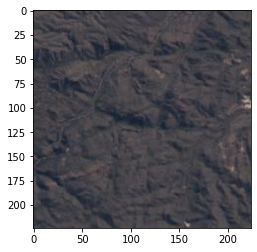

In [37]:
for images, labels in target_dataset.take(1):    # only take first element of dataset, batch in this case as it is prefetched
    
    # Batch id.
    idx = 2
    numpy_batch_images = images.numpy()
    numpy_batch_labels = labels.numpy()
    
    # Plot target img.
    plt.imshow(numpy_batch_images[idx].astype("uint8"))
    print(class_names[np.argmax(numpy_batch_labels[idx])])
    
    # Prediction.
    predictions = model.predict(numpy_batch_images)[idx]
    print('\n', predictions)
    print(class_names[np.argmax(predictions)], predictions[np.argmax(predictions)])


***

***

***

***

***

***